# $ \text{Bayesian Optimization for Recommender System}$

### $\text{Bruno Giovanni Galuzzi (University of Milano-Bicocca, 20125 Milan, MI, Italy)}$

#### Springer Nature Switzerland AG 2020
#### H. A. Le Thi et al. (Eds.): WCGO 2019, AISC 991, pp. 751–760, 2020.
#### https://doi.org/10.1007/978-3-030-21803-4_75}

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

### This dataset consists of 100.000 ratings (1–5) from 943 users on 1682 movies; thus, the rating matrix consists of 943 rows and 1682 columns, with around 100.000 known entries.

In [ ]:
data = Dataset.load_builtin('ml-100k')

### We defined the search space of possible configurations, $\Theta$ by setting the following ranges: number of latent factors $K$ in {10, 50}, both learning rate $\eta$ and regularization term $\lambda$ in [0.001, 0.1].

In [8]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# The list of hyper-parameters we want to optimize. For each one we define the bounds,
# the corresponding scikit-learn parameter name, as well as how to sample values
# from that dimension (`'log-uniform'` for the learning rate)

space  = [
            Integer(10,50, name='n_factors'),
          
            Real(0.001, 0.1,"log-uniform", name='lr_all'),
          
            Real(0.001, 0.1,"log-uniform", name='reg_all') 
]


# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set scikit-learn
# estimator parameters

@use_named_args(space)
def objective(**params):
    algo = SVD(**params)
    result = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True,n_jobs=-1)
    
    return np.around(np.mean(result['test_rmse']), decimals=4)


### $\text{Function used to minimize over the gaussian prior: "EI" for negative expected improvement. }$

In [54]:
from skopt import gp_minimize

res_gp = gp_minimize(objective, 
                     space, 
                     n_calls=50,
                     acq_func='EI',
                     base_estimator=None,
                     verbose=True,
                     n_jobs=-1)


print("Best score=%.4f" % res_gp.fun)


Iteration No: 1 started. Evaluating function at random point.
Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0329  1.0364  1.0412  1.0363  1.0465  1.0387  0.0047  
Fit time          1.85    2.30    1.93    2.31    1.93    2.06    0.20    
Test time         0.14    0.12    0.14    0.19    0.14    0.15    0.02    
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 8.4541
Function value obtained: 1.0387
Current minimum: 1.0387
Iteration No: 2 started. Evaluating function at random point.
Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0859  1.0850  1.0961  1.0999  1.0952  1.0924  0.0059  
Fit time          1.79    1.77    2.00    1.80    2.13    1.90    0.14    
Test time         0.13    0.13    0.13    0.16    0.36    0.18    0.09    
Iteration No: 2 ended. Evaluation done at rando

In [63]:
print("Best score (rmse) = %.4f" % res_gp.fun)

print("""Best hyper parameters:
- n_factors = %d
- learning_rate= %.6f
- regularization_rate = %.6f

""" % (res_gp.x[0], res_gp.x[1],res_gp.x[2]))

Best score (rmse) = 0.9129
Best hyper parameters:
- n_factors = 50
- learning_rate= 0.017731
- regularization_rate = 0.098504




### Plot one or several convergence traces.

In [52]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.ticker import LogLocator
from matplotlib.ticker import MaxNLocator

from scipy.optimize import OptimizeResult
def plot_convergence1(*args, **kwargs):
    """Plot one or several convergence traces.

    Parameters
    ----------
    * `args[i]` [`OptimizeResult`, list of `OptimizeResult`, or tuple]:
        The result(s) for which to plot the convergence trace.

        - if `OptimizeResult`, then draw the corresponding single trace;
        - if list of `OptimizeResult`, then draw the corresponding convergence
          traces in transparency, along with the average convergence trace;
        - if tuple, then `args[i][0]` should be a string label and `args[i][1]`
          an `OptimizeResult` or a list of `OptimizeResult`.

    * `ax` [`Axes`, optional]:
        The matplotlib axes on which to draw the plot, or `None` to create
        a new one.

    * `true_minimum` [float, optional]:
        The true minimum value of the function, if known.

    * `yscale` [None or string, optional]:
        The scale for the y-axis.

    Returns
    -------
    * `ax`: [`Axes`]:
        The matplotlib axes.
    """
    # <3 legacy python
    ax = kwargs.get("ax", None)
    true_minimum = kwargs.get("true_minimum", None)
    yscale = kwargs.get("yscale", None)

    if ax is None:
        ax = plt.gca()

    ax.set_title("Convergence plot")
    ax.set_xlabel("Number of calls $n$")
    ax.set_ylabel(r"$\min$ RMSE after $n$ calls")
#     ax.grid()

    if yscale is not None:
        ax.set_yscale(yscale)

    colors = cm.viridis(np.linspace(0.25, 1.0, len(args)))

    for results, color in zip(args, colors):
        if isinstance(results, tuple):
            name, results = results
        else:
            name = None

        if isinstance(results, OptimizeResult):
            n_calls = len(results.x_iters)
            mins = [np.min(results.func_vals[:i])
                    for i in range(1, n_calls + 1)]
            ax.plot(range(1, n_calls + 1), mins, c=color,
                    marker=".", markersize=12, lw=2, label=name)

        elif isinstance(results, list):
            n_calls = len(results[0].x_iters)
            iterations = range(1, n_calls + 1)
            mins = [[np.min(r.func_vals[:i]) for i in iterations]
                    for r in results]

            for m in mins:
                ax.plot(iterations, m, c=color, alpha=0.2)

            ax.plot(iterations, np.mean(mins, axis=0), c=color,
                    marker=".", markersize=12, lw=2, label=name)

    if true_minimum:
        ax.axhline(true_minimum, linestyle="--",
                   color="r", lw=1,
                   label="True minimum")

    if true_minimum or name:
        ax.legend(loc="best")

    return ax

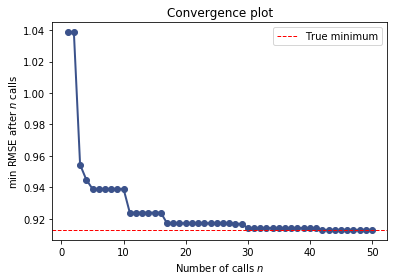

In [60]:
plot_convergence1(res_gp,true_minimum=0.9129)

### Test hyperparameters as the mean of 5-fold cross-validation.

### True minimum should be $\approx 0.9129$

In [61]:
algo_1 = SVD(  
               n_factors=50,
               lr_all=0.017731,
               reg_all=0.098504
            )



cross_validate(algo_1, data, measures=['RMSE'], return_train_measures=True, cv=5, verbose=True,n_jobs=-1)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9125  0.9132  0.9163  0.9053  0.9158  0.9126  0.0039  
RMSE (trainset)   0.7451  0.7473  0.7434  0.7449  0.7430  0.7447  0.0015  
Fit time          2.45    14.28   2.41    2.14    2.22    4.70    4.79    
Test time         0.15    0.37    0.15    0.14    0.13    0.19    0.09    


{'test_rmse': array([0.91250978, 0.91322019, 0.91632901, 0.90532169, 0.91580417]),
 'train_rmse': array([0.74512153, 0.74726468, 0.74337267, 0.74485185, 0.74300728]),
 'fit_time': (2.447819471359253,
  14.276379346847534,
  2.4119374752044678,
  2.141545295715332,
  2.2218496799468994),
 'test_time': (0.15401172637939453,
  0.3665006160736084,
  0.14890599250793457,
  0.13584613800048828,
  0.12658190727233887)}